In [1]:
import xarray as xr
import climtas
import xesmf
import cf_xarray

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Client Scheduler: tcp://127.0.0.1:35629 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


In [3]:
ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/monthly_Rx1day_all_members.nc', chunks={'member':1, 'time':200})
ds

,Array,Chunk
Bytes,77.81 GiB,100.00 MiB
Shape,"(80, 1992, 256, 512)","(1, 200, 256, 512)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [4]:
data = ds.PRATE

In [5]:
data

,Array,Chunk
Bytes,77.81 GiB,100.00 MiB
Shape,"(80, 1992, 256, 512)","(1, 200, 256, 512)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [8]:
sample_ds = xr.open_dataset('/g/data/w40/rl5183/sample_grid_1x1.nc')

In [9]:
sample_ds

<xarray.Dataset>
Dimensions:             (lat: 180, lon: 360)
Coordinates:
  * lon                 (lon) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    GDP_per_capita_PPP  (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Sep 15 15:46:12 2021: cdo remapcon,r360x180 gdp_ppp_201...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [10]:
ds_bnds = ds.cf.add_bounds(['lat','lon'])
sample_bnds = sample_ds.cf.add_bounds(['lat','lon'])

In [11]:
regrid = xesmf.Regridder(ds_bnds, sample_bnds, method='conservative_normed')

In [12]:
data_regrid = regrid(data)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [13]:
data_regrid

,Array,Chunk
Bytes,76.94 GiB,98.88 MiB
Shape,"(80, 1992, 180, 360)","(1, 200, 180, 360)"
Count,3201 Tasks,800 Chunks
Type,float64,numpy.ndarray


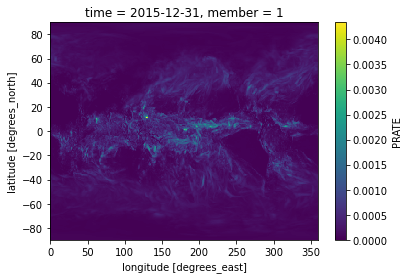

In [14]:
data.isel(member=0).isel(time=-1).plot()

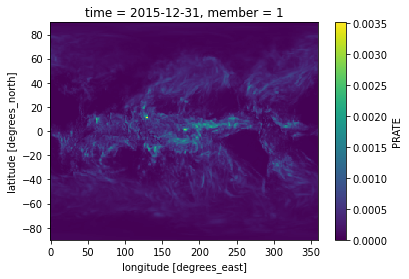

In [15]:
data_regrid.isel(member=0).isel(time=-1).plot()

In [16]:
# save as netcdf
climtas.io.to_netcdf_throttled(data_regrid, '/g/data/w40/rl5183/20CR/precip/monthly_Rx1day_all_members_1x1.nc')

  0%|          | 0/800 [00:00<?, ?it/s]

In [14]:
check = xr.open_dataset('/g/data/w40/rl5183/20CR/temp/monthly_TNn_all_members_1x1.nc', chunks={'member':1, 'time':200})

In [15]:
check.TMP2m

,Array,Chunk
Bytes,76.94 GiB,98.88 MiB
Shape,"(80, 1992, 180, 360)","(1, 200, 180, 360)"
Count,801 Tasks,800 Chunks
Type,float64,numpy.ndarray


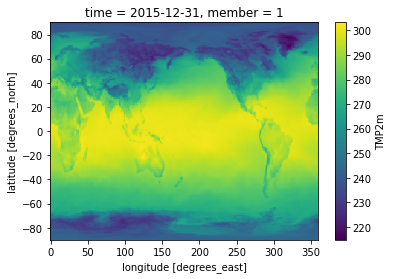

In [16]:
check.TMP2m.isel(member=0).isel(time=-1).plot()

In [17]:
TXx_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_TXx_MON_regrid_144x73.nc')

In [18]:
TXx_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1416)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-15 1901-02-15 ... 2018-12-15
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    TXx      (time, lat, lon) float32 ...
Attributes: (12/33)
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    Conventions:                CF-1.6
    history:                    Mon Jul 05 14:12:37 2021: cdo remapcon,r144x7...
    source:                     HadEX3 data product
    institution:                Met Office Hadley Centre, Exeter, UK
    title:                      TXx
    ...                         ...
    geospatial_lon_resolution:  1.875
    time_coverage_resolution:   Monthly
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    DOI:                        https://doi.org/10.1029/2019JD032263
    dataset_version:            3.0.3
    CDO:                        Climate Data Operators version 1.9.8 (https:/...